In [17]:
import os
import urllib.request
import zipfile

url = 'https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip'
data_dir = './data/'
model_name = os.path.split(url)[-1]
local_zip_file = os.path.join(data_dir, model_name)

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(local_zip_file):
    print("Downloading model...")
    model_url = urllib.request.urlopen(url)
    with open(local_zip_file, 'wb') as output:
        output.write(model_url.read())
    print("Download complete.")

    with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
        print("Extraction complete.")
else:
    print("Model already downloaded.")



Download complete.
Extraction complete.


In [18]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

model_fn = 'tensorflow_inception_graph.pb'

graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

with tf.gfile.FastGFile(os.path.join(data_dir, model_fn), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

t_input = tf.placeholder(np.float32, name='input')
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input - imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input': t_preprocessed})

# Check loaded layers
layers = [op.name for op in graph.get_operations() if op.type == 'Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name + ':0').get_shape()[-1]) for name in layers]

print("Loaded %d layers" % len(layers))
print("Total feature channels: %d" % sum(feature_nums))


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use tf.gfile.GFile.
Loaded 59 layers
Total feature channels: 7548


In [19]:
import matplotlib.pyplot as plt
from functools import partial
import PIL.Image

def showarray(a):
    a = np.uint8(np.clip(a, 0, 1) * 255)
    plt.imshow(a)
    plt.axis('off')
    plt.show()

def visstd(a, s=0.1):
    return (a - a.mean()) / max(a.std(), 1e-4) * s + 0.5

def T(layer):
    return graph.get_tensor_by_name("import/%s:0" % layer)

def tffunc(*argtypes):
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0, :, :, :]
resize = tffunc(np.float32, np.int32)(resize)


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


In [20]:
def calc_grad_tiled(img, t_grad, tile_size=512):
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h - sz // 2, sz), sz):
        for x in range(0, max(w - sz // 2, sz), sz):
            sub = img_shift[y:y+sz, x:x+sz]
            g = sess.run(t_grad, {t_input: sub})
            grad[y:y+sz, x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

def render_deepdream(t_obj, img0,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_score, t_input)[0]

    img = img0.copy()
    octaves = []
    for _ in range(octave_n - 1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw) / octave_scale))
        hi = img - resize(lo, hw)
        img = lo
        octaves.append(hi)

    for octave in range(octave_n):
        if octave > 0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2]) + hi
        for _ in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g * (step / (np.abs(g).mean() + 1e-7))
        showarray(img / 255.0)


In [28]:
img_path = 'images/my_cat.jpg'
img0 = PIL.Image.open(img_path)
img0 = np.float32(img0)


I0000 00:00:1753863084.485484 2658980 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


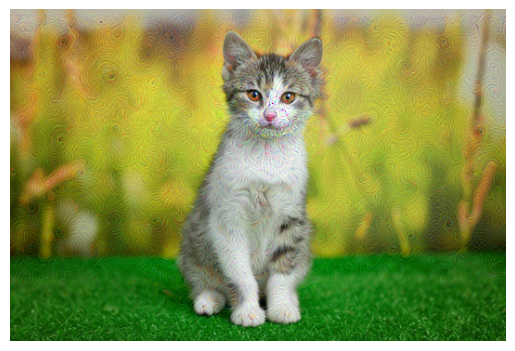

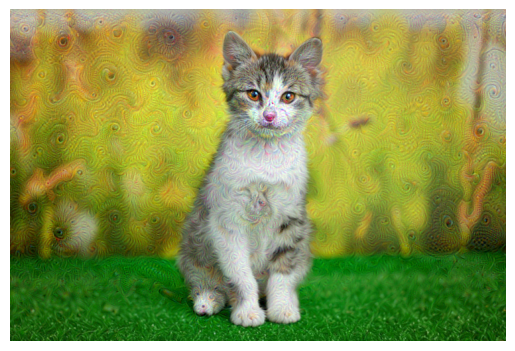

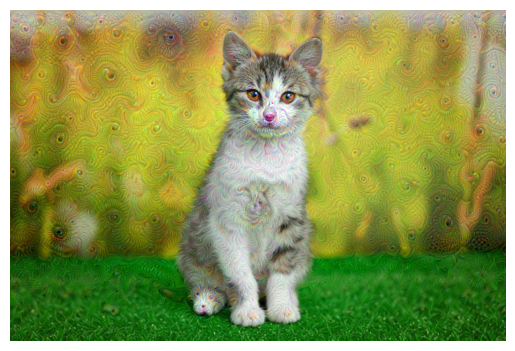

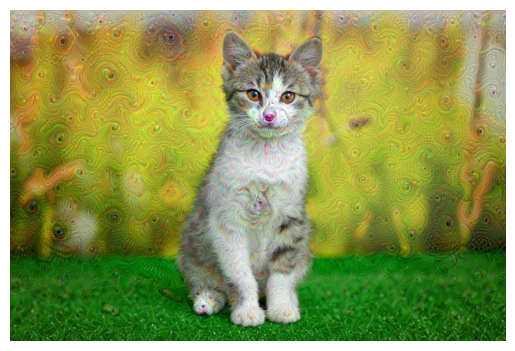

In [29]:
# You can change the layer or even the channel
render_deepdream(tf.square(T('mixed4c')), img0)
